# Pylops - wave equation processing

### Author: M.Ravasi

Many processing step in the seismic processing chain lend naturally to the creation and solution of large scale systems of equations. 

One of the most common building blocks of wave-equation-based processing of seismic data is the so-called multi-dimensional convolution (MDC) operator. Such an operator underlies some of the most common algorithms such SRME, IME and interferometry by multi-dimensional deconvolution (MDD) and Marchenko-based redatuming. 

In this notebook I will show you how to use the **MDC** linear operator of *Pylops* and I will present two applications of such operator:

- Multi-dimensional deconvolution (MDD)
- SRME prediction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

# Application1: Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ y(s,v,f) = \int_S R(s,v,f) x(r,v,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':400,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.05,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear2d(x,t,v,t0_m,theta_m,amp_m,wav)

# Generate operator
G,Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

In [3]:
# Define MDC linear operator
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], dtype='complex64')
dottest(MDCop, (2*par['nt']-1)*par['ny'], (2*par['nt']-1)*par['nx'], verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(par['ny'], 2*par['nt']-1)

Dot test passed, v^T(Opu)=1448.177617 - u^T(Op^Tv)=1448.177617


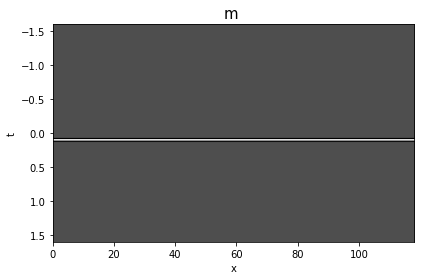

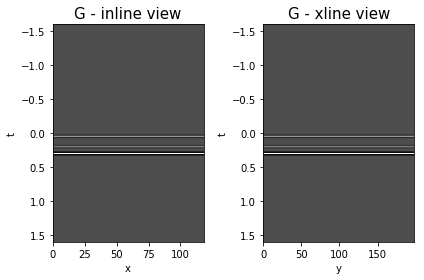

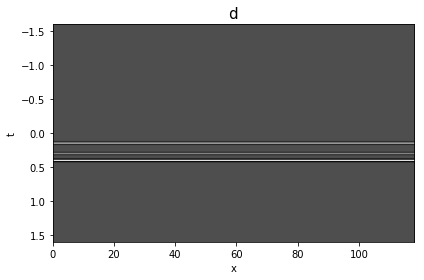

In [4]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.imshow(d.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## Application 1: Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

Let's take from where we left and invert our MDC operator

In [5]:
madj = MDCop.H*d.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.flatten(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(par['nx'], 2*par['nt']-1)
minv = minv.reshape(par['nx'], 2*par['nt']-1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    79900 rows  and    47940 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.075e+02  6.075e+02    1.0e+00  3.5e-01
     1  2.05408e-11   3.382e+02  3.382e+02    5.6e-01  7.1e-01   2.6e+02  1.0e+00
     2  5.35323e-11   1.981e+02  1.981e+02    3.3e-01  3.7e-01   3.6e+02  2.3e+00
     3  9.55186e-11   1.457e+02  1.457e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4  1.52563e-10   1.086e+02  1.086e+02    1.8e-01  2.3e-01   4.9e+02  5.2e+00
     5 -3.91262e-09   8.804e+01  8.804e+01    1.4e-01  2.0e-01   5.4e+02  6.8e+00
     6 -1.73238e-05   7.267e+01  7.267e+01    1.2e-01  1.5e-01   5.9e+02  8.6e+00
     7  3.59669e-05   6.147e+01  6.147e+01    1.0e-01  1.2e-01   6.3e+02  1.1e+01
     8  9.59186e-04   5.281e

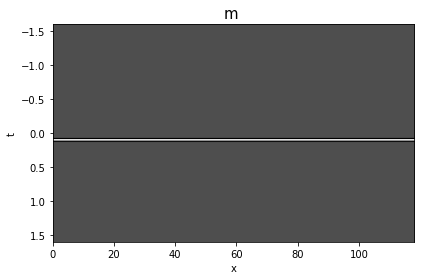

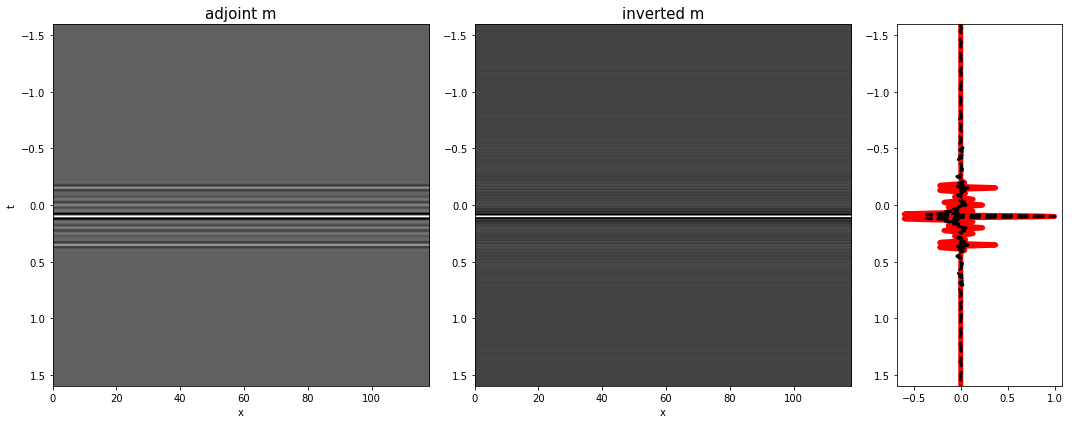

In [6]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We solve now the same problem with a preconditioning

$$\mathbf{d}= \mathbf{D} \mathbf{P} \mathbf{m}$$

where $\mathbf{P}$ is a masking operator that sets values in the negative part of the time axis equal to zero. This is added here as we know that our solution should be null in the negative time axis and it can be used to speed up convergence.

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    79900 rows  and    47940 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.075e+02  6.075e+02    1.0e+00  3.3e-01
     1  0.00000e+00   3.230e+02  3.230e+02    5.3e-01  7.6e-01   2.3e+02  1.0e+00
     2  0.00000e+00   1.889e+02  1.889e+02    3.1e-01  4.2e-01   3.4e+02  2.2e+00
     3  0.00000e+00   1.378e+02  1.378e+02    2.3e-01  2.9e-01   4.1e+02  3.5e+00
     4  0.00000e+00   1.071e+02  1.071e+02    1.8e-01  2.3e-01   4.8e+02  5.0e+00
     5  0.00000e+00   8.813e+01  8.813e+01    1.5e-01  1.9e-01   5.3e+02  6.7e+00
     6  0.00000e+00   7.254e+01  7.254e+01    1.2e-01  1.7e-01   5.8e+02  8.6e+00
     7  0.00000e+00   5.905e+01  5.905e+01    9.7e-02  1.3e-01   6.2e+02  1.1e+01
     8  0.00000e+00   4.790e

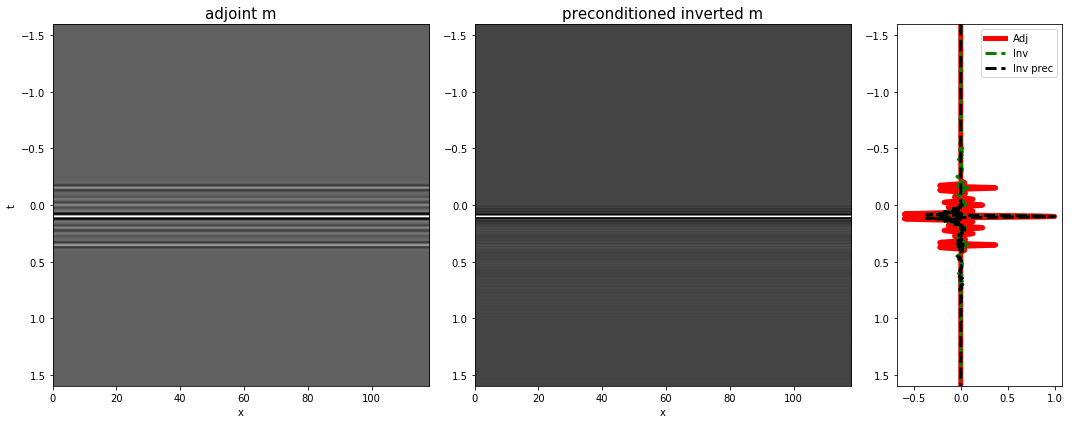

In [7]:
P = np.ones((par['nx'],par['nt']*2-1))
P[:,:par['nt']-1]=0
Pop = Diagonal(P)

minv_prec= PreconditionedInversion(MDCop, Pop, d.flatten(), returninfo=True,
                                   **dict(damp=1e-10, iter_lim=10, show=1))[0]

minv_prec = minv_prec.reshape(par['nx'], 2*par['nt']-1)
 
            
# Plotting
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv_prec.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('preconditioned inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5, label='Adj')
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--g', lw=3, label='Inv')
ax3.plot(minv_prec[int(par['nx']/2)]/np.abs(minv_prec[int(par['nx']/2)]).max(), t2, '--k', lw=3, label='Inv prec')
ax3.set_ylim([t2[-1],t2[0]])
ax3.legend()
fig.tight_layout()

Let's now take advantage of the high level MDD routine

Dot test passed, v^T(Opu)=1059.434851 - u^T(Op^Tv)=1059.434851
Dot test passed, v^T(Opu)=812.119460 - u^T(Op^Tv)=812.119460
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    79900 rows  and    47940 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.075e+02  6.075e+02    1.0e+00  3.5e-01
     1  1.00076e-17   3.382e+02  3.382e+02    5.6e-01  7.1e-01   2.6e+02  1.0e+00
     2 -2.63319e-09   1.981e+02  1.981e+02    3.3e-01  3.7e-01   3.6e+02  2.3e+00
     3 -2.74007e-09   1.457e+02  1.457e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4 -1.54264e-09   1.086e+02  1.086e+02    1.8e-01  2.3e-01   4.9e+02  5.2e+00
     5 -3.84159e-09   8.804e+01  8.804e+01    1.4e-01  2.0e-01   5.4e+02  6.8e+00
     6 -1.73217e-05   7.267e+01  7.267e+01    1.2e-01  1.5e-01   5.9

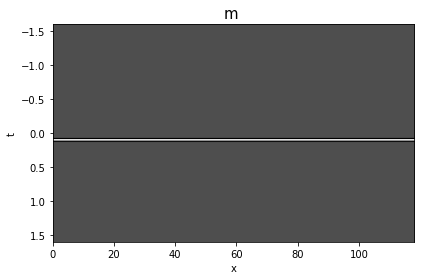

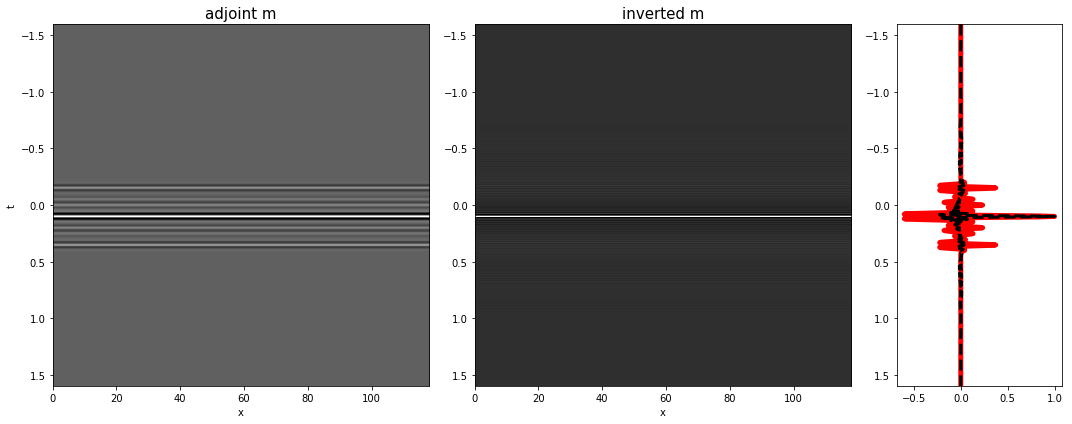

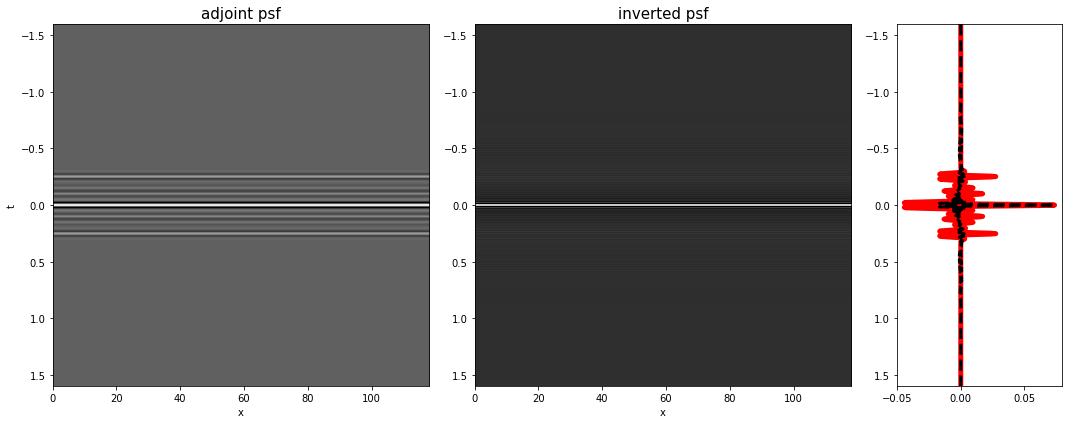

In [8]:
minv,madj,psfinv,psfadj = MDD(Gwav, d[:,par['nt']-1:], 
                              dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, 
                              adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-10, iter_lim=50, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()


fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(par['ny']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['ny']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

And same with preconditioner

Dot test passed, v^T(Opu)=461.996193 - u^T(Op^Tv)=461.996193
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    79900 rows  and    47940 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.075e+02  6.075e+02    1.0e+00  3.3e-01
     1  0.00000e+00   3.230e+02  3.230e+02    5.3e-01  7.6e-01   2.3e+02  1.0e+00
     2  0.00000e+00   1.889e+02  1.889e+02    3.1e-01  4.2e-01   3.4e+02  2.2e+00
     3  0.00000e+00   1.378e+02  1.378e+02    2.3e-01  2.9e-01   4.1e+02  3.5e+00
     4  0.00000e+00   1.071e+02  1.071e+02    1.8e-01  2.3e-01   4.8e+02  5.0e+00
     5  0.00000e+00   8.813e+01  8.813e+01    1.5e-01  1.9e-01   5.3e+02  6.7e+00
     6  0.00000e+00   7.254e+01  7.254e+01    1.2e-01  1.7e-01   5.8e+02  8.6e+00
     7  0.00000e+00   5.905e+01  5.905e+01    9.7

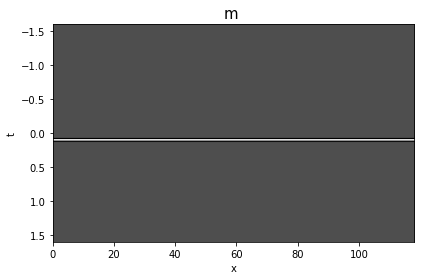

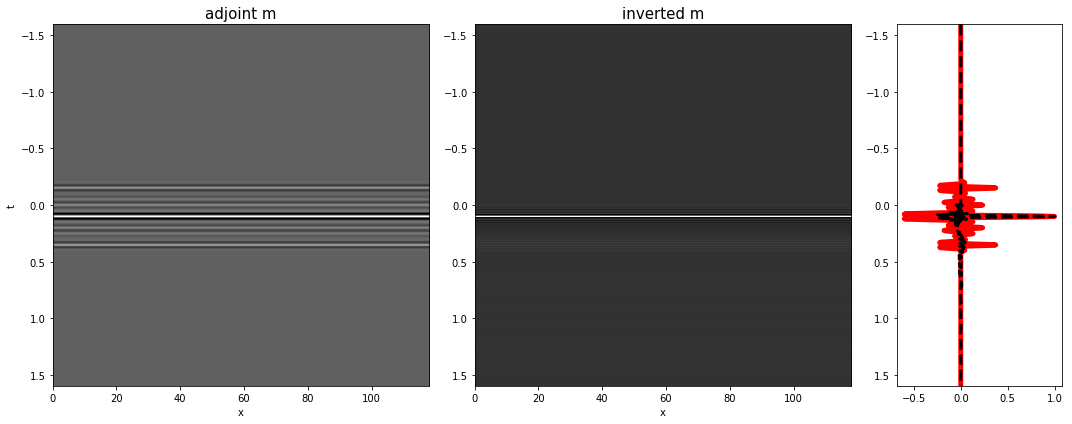

In [9]:
minv,madj = MDD(Gwav, d[:,par['nt']-1:], 
                dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, 
                causality_precond=True, adjoint=True, psf=False, 
                dtype='complex64', dottest=True, 
                **dict(damp=1e-10, iter_lim=30, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We consider now a case with multiple virtual sources

In [10]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':300,
       'f0': 20, 'nfmax': 201}

v       = 1500
t0_m    = [0.2]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.1,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear3d(x,x,t,v,t0_m,theta_m,phi_m,amp_m,wav)

# Generate operator
G, Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

In [11]:
# Create operator in frequency domain
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft, nt=2*par['nt']-1, nv=par['nx'], dt=par['dt'], dr=par['dx'], dtype='float32')
dottest(MDCop, (2*par['nt']-1)*par['nx']*par['ny'],(2*par['nt']-1)*par['nx']*par['nx'], verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(par['ny'], par['nx'], 2*par['nt']-1)

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav, d[:,:,par['nt']-1:], 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], twosided=True, 
                              adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-10, iter_lim=5, show=1))

Dot test passed, v^T(Opu)=-4637.627240 - u^T(Op^Tv)=-4637.627240
Dot test passed, v^T(Opu)=-41007.068133 - u^T(Op^Tv)=-41007.068133
Dot test passed, v^T(Opu)=5473.219351 - u^T(Op^Tv)=5473.219351
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 3.594e+06 rows  and 2.1564e+06 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =        5
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.074e+03  4.074e+03    1.0e+00  4.6e-02
     1 -2.80918e-16   2.299e+03  2.299e+03    5.6e-01  6.6e-01   2.3e+02  1.0e+00
     2 -1.11743e-11   1.320e+03  1.320e+03    3.2e-01  3.8e-01   3.1e+02  2.3e+00
     3 -1.49171e-11   1.005e+03  1.005e+03    2.5e-01  2.7e-01   3.7e+02  3.5e+00
     4  5.31027e-08   7.646e+02  7.646e+02    1.9e-01  2.4e-01   4.2e+02  5.2e+00
     5  7.05190e-04   6.112e+02  6.112e+02    1.5e-01  2.0e-01   4.7e+02  6.

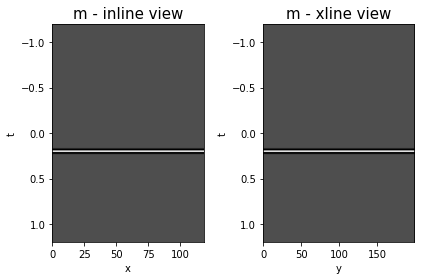

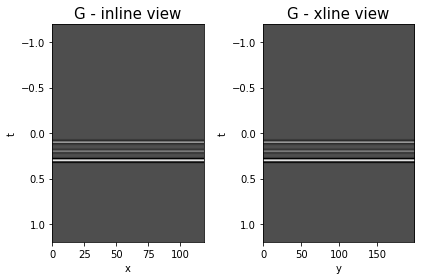

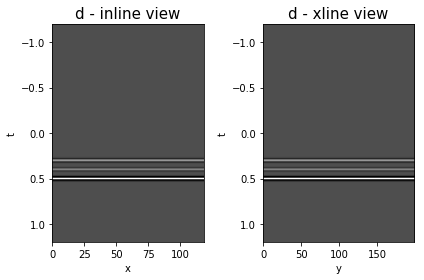

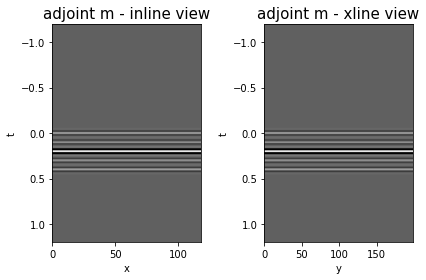

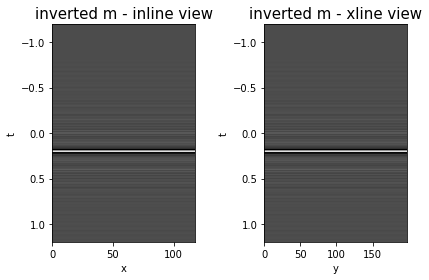

In [12]:
# Plotting
plt.figure()
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(d[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(d[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(madj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

And finally, same as before but without padding the data and operators with zero in negative axis

In [13]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':401,
       'f0': 20, 'nfmax': 200}

v       = 1500
t0_m    = [0.2]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.1,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear3d(x,x,t,v,t0_m,theta_m,phi_m,amp_m,wav)

# Generate operator
G,Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

Gwav_fft = np.fft.rfft(Gwav, par['nt'], axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

In [14]:
# Define MDC linear operator
MDCop=MDC(Gwav_fft, nt=par['nt'], nv=par['nx'], dt=par['dt'], dr=par['dx'], twosided=False, dtype='float32')
dottest(MDCop, par['nt']*par['nx']*par['ny'], par['nt']*par['nx']*par['nx'], verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(par['ny'], par['nx'], par['nt'])

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav, d, 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], twosided=False, 
                              adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-10, iter_lim=5,show=1))

Dot test passed, v^T(Opu)=7549.404078 - u^T(Op^Tv)=7549.404078
Dot test passed, v^T(Opu)=-2592.274328 - u^T(Op^Tv)=-2592.274328
Dot test passed, v^T(Opu)=509.050642 - u^T(Op^Tv)=509.050642
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2.406e+06 rows  and 1.4436e+06 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =        5
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.334e+03  3.334e+03    1.0e+00  4.6e-02
     1  3.26855e-02   1.881e+03  1.881e+03    5.6e-01  6.6e-01   1.9e+02  1.0e+00
     2  4.07262e-02   1.080e+03  1.080e+03    3.2e-01  3.8e-01   2.6e+02  2.3e+00
     3  3.84982e-02   8.226e+02  8.226e+02    2.5e-01  2.8e-01   3.1e+02  3.5e+00
     4  2.97694e-02   6.439e+02  6.439e+02    1.9e-01  2.5e-01   3.5e+02  5.2e+00
     5  2.03844e-02   4.918e+02  4.918e+02    1.5e-01  1.7e-01   3.9e+02  7.1e+00


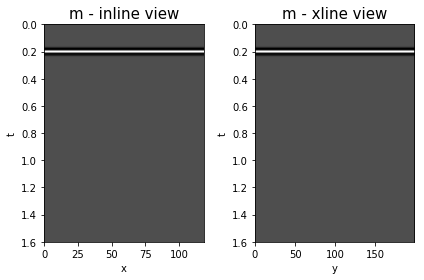

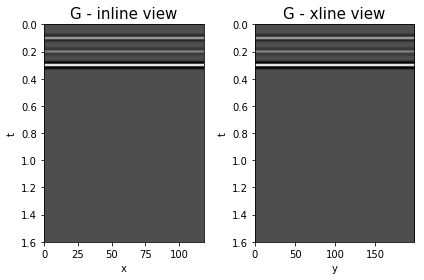

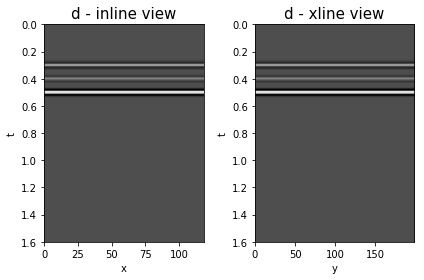

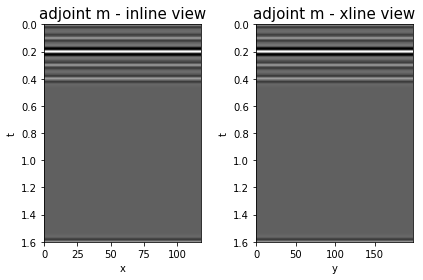

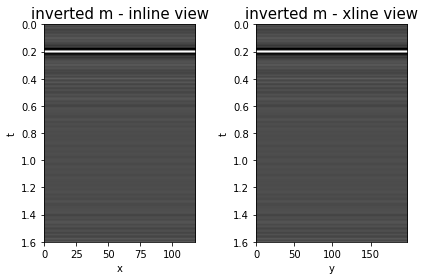

In [15]:
# Plotting
plt.figure()
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(d[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(d[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(madj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

Let's now repeat the same exercise with hyperbolic events

In [16]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]


# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
#G,Gwav = hyperbolic3d(x,y,t,t0_G,vrms_G,vrms_G,amp_G,wav)
G,Gwav = np.zeros((par['ny'],par['nx'],par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)

G,Gwav = G*tap,Gwav*tap

In [17]:
# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

# Define MDC linear operator
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=0.004, dr=1., dtype='float32')
dottest(MDCop, (2*par['nt']-1)*par['ny'], (2*par['nt']-1)*par['nx'], verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(par['ny'], 2*par['nt']-1)

#madj = MDCop.H*d.flatten()
#minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.flatten(), damp=1e-4, iter_lim=200,show=1)[0:5]

#madj = madj.reshape(par['nx'], 2*par['nt']-1)
#minv = minv.reshape(par['nx'], 2*par['nt']-1)

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav, d[:,par['nt']-1:], 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                              twosided=True, adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-4, iter_lim=50,show=1))

Dot test passed, v^T(Opu)=426.839159 - u^T(Op^Tv)=426.839159
Dot test passed, v^T(Opu)=2985.445330 - u^T(Op^Tv)=2985.445330
Dot test passed, v^T(Opu)=20799.203353 - u^T(Op^Tv)=20799.203353
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    80699 rows  and    48739 cols
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.920e+01  2.920e+01    1.0e+00  4.4e+00
     1  0.00000e+00   1.896e+01  1.896e+01    6.5e-01  6.8e-01   1.7e+02  1.0e+00
     2  0.00000e+00   1.310e+01  1.310e+01    4.5e-01  4.2e-01   2.5e+02  2.4e+00
     3  0.00000e+00   1.000e+01  1.000e+01    3.4e-01  2.9e-01   3.2e+02  3.8e+00
     4  0.00000e+00   8.067e+00  8.067e+00    2.8e-01  2.2e-01   3.7e+02  5.4e+00
     5  0.00000e+00   6.597e+00  6.597e+00    2.3e-01  1.8e-01   4.1e+02  7.2e+00
   

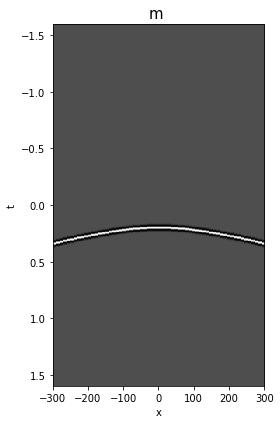

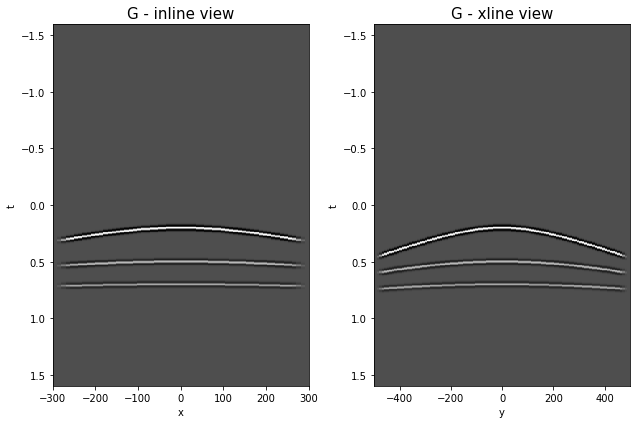

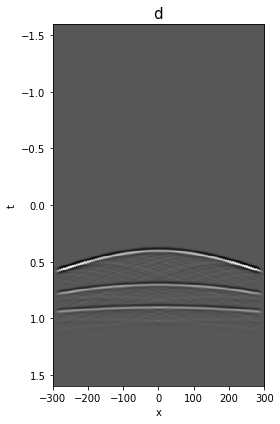

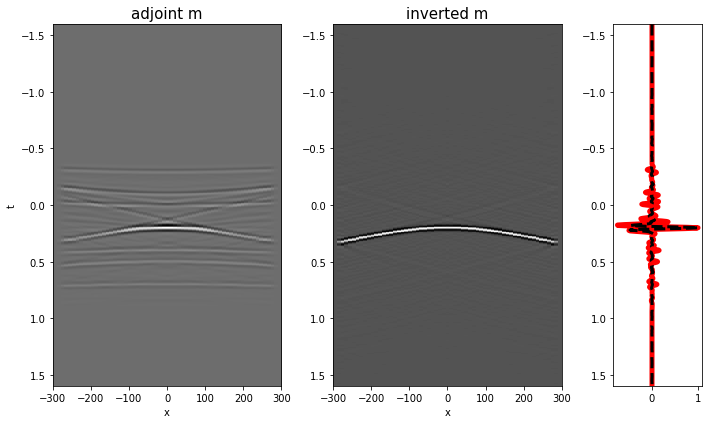

In [18]:
# Plotting
plt.figure(figsize=(4,6))
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(4,6))
plt.imshow(d.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')
ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r',   lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

And 3d to finish

In [19]:
# Generate model
m, mwav =  hyperbolic3d(x,x,t,t0_m,vrms_m,vrms_m,amp_m,wav)
m, mwav = np.zeros((par['nx'],par['nx'],par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    m[ix],mwav[ix] = hyperbolic2d(x-x0,t,t0_m,vrms_m,amp_m,wav)


# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)), mwav), axis=-1)

MDCop=MDC(Gwav_fft, nt=2*par['nt']-1, nv=par['nx'], dt=par['dt'], dr=par['dx'], dtype='float32')
dottest(MDCop, (2*par['nt']-1)*par['nx']*par['ny'],(2*par['nt']-1)*par['nx']*par['nx'], verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(par['ny'], par['nx'], 2*par['nt']-1)

#madj = MDCop.H*d.flatten()
#minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.flatten(), damp=1e-10, iter_lim=5, show=1)[0:5]

#madj = madj.reshape(par['nx'], par['nx'], 2*par['nt']-1)
#minv = minv.reshape(par['nx'], par['nx'], 2*par['nt']-1)

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav, d[:,:,par['nt']-1:], 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav=wav,
                              twosided=True, adjoint=True, psf=True, 
                              dtype='complex64', dottest=True, 
                              **dict(damp=1e-10, iter_lim=50,show=1))

Dot test passed, v^T(Opu)=12129.682994 - u^T(Op^Tv)=12129.682994
Dot test passed, v^T(Opu)=-76004.820337 - u^T(Op^Tv)=-76004.820337
Dot test passed, v^T(Opu)=27619.226077 - u^T(Op^Tv)=27619.226077
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 4.92264e+06 rows  and 2.97308e+06 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.306e+03  2.306e+03    1.0e+00  5.7e-02
     1  0.00000e+00   1.362e+03  1.362e+03    5.9e-01  7.3e-01   1.6e+02  1.0e+00
     2  0.00000e+00   9.460e+02  9.460e+02    4.1e-01  4.1e-01   2.5e+02  2.3e+00
     3  0.00000e+00   7.142e+02  7.142e+02    3.1e-01  2.9e-01   3.1e+02  3.7e+00
     4  0.00000e+00   5.855e+02  5.855e+02    2.5e-01  2.2e-01   3.7e+02  5.3e+00
     5  0.00000e+00   4.874e+02  4.874e+02    2.1e-01  1.8e-01   4.1e+0

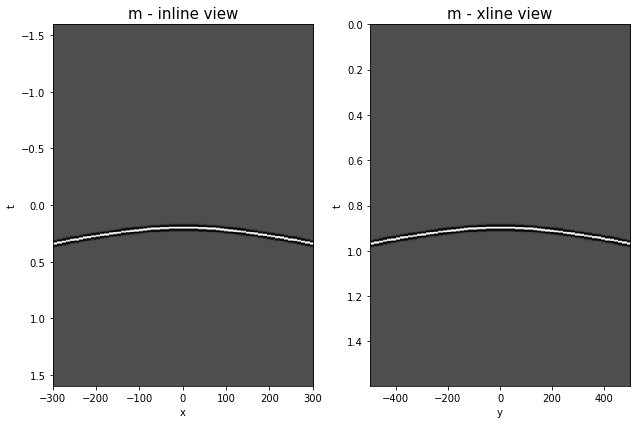

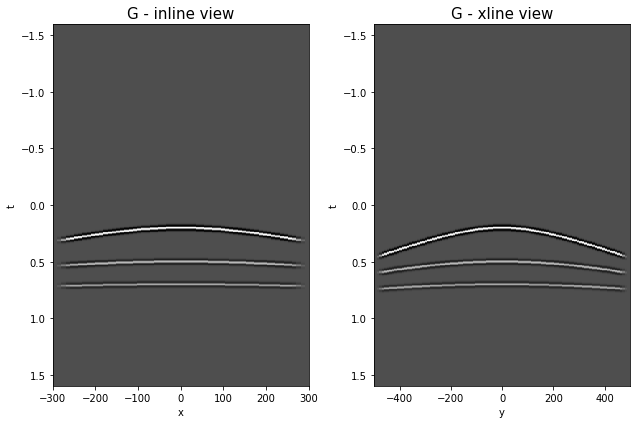

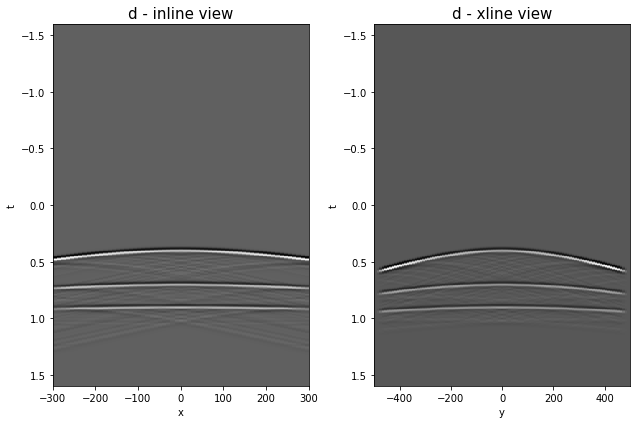

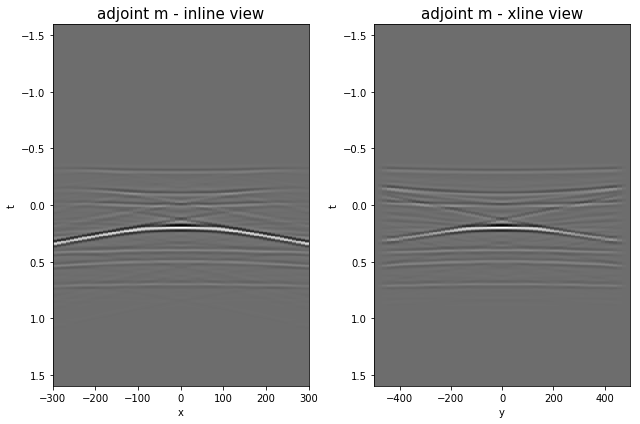

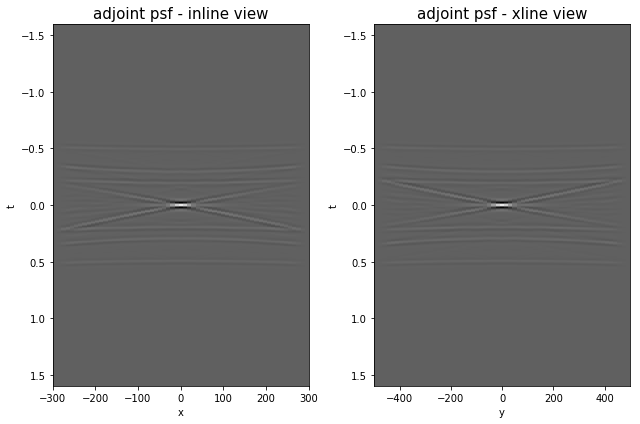

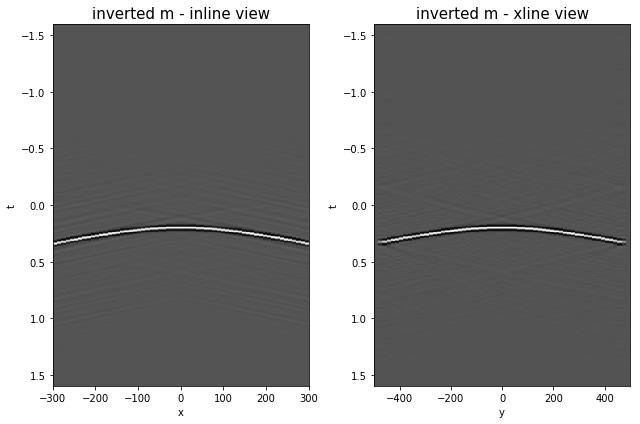

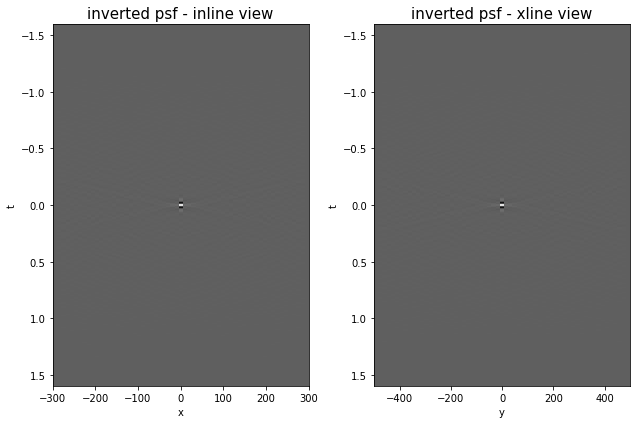

In [20]:
# Plotting
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(d[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(d[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(madj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfadj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(psfadj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfinv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(psfinv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

# Application2: SRME prediction

The same operator can be used to perform the prediction step of SRME algorithm. 

We first create a primary only data called $P_0 = R*W$ where $R$ is the medium reflectivity and $W$ the source wavelet. 

We then create the full data by evaluating the following series

$$\mathbf{p} = \sum_{i=1}^{n_{iter}} (r\mathbf{R})^i \mathbf{p_0}$$

where $r$ is the free-surface reflectivity.

Finally we make an approximate (kinematically correct but dynamically incorrect) estimate of the free-surface multiples by simple cross-correlation of the data

$$\mathbf{M} =  \mathbf{P} \mathbf{p}$$

where $\mathbf{P}$ is a MDC linear operator that convolves the input with the full data.

In [21]:
###### Input parameters
par = {'ox':-500,  'dx':5,     'nx':201,
       'ot':0,     'dt':0.004, 'nt':301,
       'f0':40,    'nfmax':151}

t0_P    = [0.2]
vrms_P  = [1400.]
amp_P   = [1.]
r       = -.9

niters  = 6

# Create axis
t,t2,x,_ = makeaxis(par)

# Create wavelets
wav      = ricker(t[:41], f0=par['f0'])[0] # sampled to 0.5ms

# Create taper for operator
tap = taper3d(par['nt'], [par['nx'], par['nx']], [15,15], tapertype='hanning')

# Generate primary data
R, P0 = np.zeros((par['nx'],par['nx'],par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    R[ix],P0[ix] = hyperbolic2d(x-x0,t,t0_P,vrms_P,amp_P,wav)
R, P0 = R*tap,P0*tap

# Create operator
R_fft = np.fft.rfft(R, par['nt'], axis=-1) / np.sqrt(par['nt'])
R_fft = R_fft[...,:par['nfmax']]# Define MDC linear operator
Rop=MDC(R_fft, nt=par['nt'], nv=par['nx'], dt=par['dt'], dr=par['dx'], twosided=False, dtype='float32')
dottest(Rop, par['nt']*par['nx']*par['nx'], par['nt']*par['nx']*par['nx'], verb=True)

# Create full data
P  = P0.copy()
dP = P0.copy()
for i in range(niters):
    print('Construct contribution %d/%d' %(i,niters))
    dP = (r*Rop*dP.flatten()).reshape(par['nx'], par['nx'], par['nt'])
    P += dP
    
# Estimate multiples
P_fft = np.fft.rfft(P, par['nt'], axis=-1)
P_fft = P_fft[...,:par['nfmax']]
Pop=MDC(P_fft, nt=par['nt'], nv=par['nx'], dt=par['dt'], dr=par['dx'], twosided=False, dtype='float32')
dottest(Pop, par['nt']*par['nx']*par['nx'], par['nt']*par['nx']*par['nx'], verb=True)

Mest = -Pop*P.flatten()
Mest = Mest.reshape(par['nx'], par['nx'], par['nt'])

Dot test passed, v^T(Opu)=1031.474760 - u^T(Op^Tv)=1031.474760
Construct contribution 0/6
Construct contribution 1/6
Construct contribution 2/6
Construct contribution 3/6
Construct contribution 4/6
Construct contribution 5/6
Dot test passed, v^T(Opu)=-8701.309357 - u^T(Op^Tv)=-8701.309357


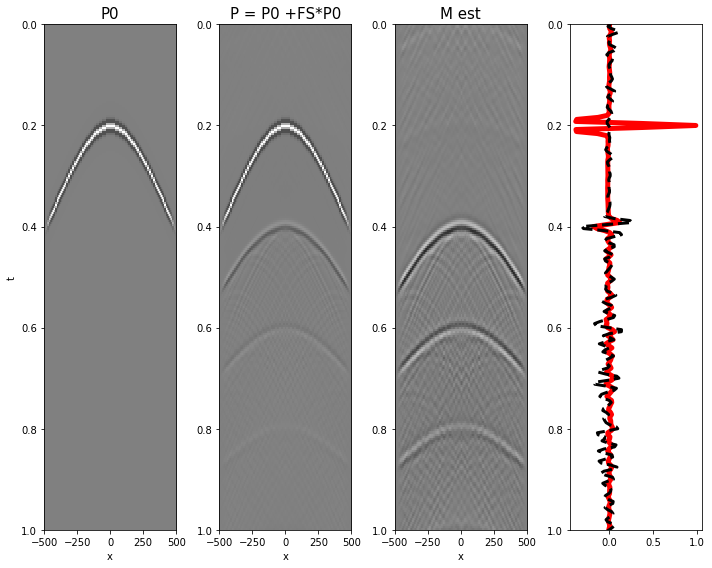

In [22]:
# Plotting
tmax=1.

fig, axs = plt.subplots(1,4,figsize=(10,8))
axs[0].imshow(P0[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[0].set_title('P0', fontsize=15)
axs[0].set_xlabel('x'),axs[0].set_ylabel('t')
axs[0].set_ylim([tmax,t[0]])

axs[1].imshow(P[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[1].set_title('P = P0 +FS*P0', fontsize=15)
axs[1].set_xlabel('x'),axs[0].set_ylabel('t')
axs[1].set_ylim([tmax,t[0]])

axs[2].imshow(Mest[int(par['nx']/2)].T/Mest.max(),aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[2].set_title('M est', fontsize=15)
axs[2].set_xlabel('x'),axs[0].set_ylabel('t')
axs[2].set_ylim([tmax,t[0]])

axs[3].plot(P[int(par['nx']/2),int(par['nx']/2)].T/np.abs(P).max(),       t, 'r',   lw=5)
axs[3].plot(Mest[int(par['nx']/2),int(par['nx']/2)].T/np.abs(Mest).max(), t, '--k', lw=3)
axs[3].set_ylim([tmax,t[0]])
plt.tight_layout()